##### Deep Convolution Generative Adversarial Network to stock price difference using previous trading day data and technical indicators. The output of the Generative model is the next day stock price difference data which is appended to last 3 trading days difference and is then fed to the Discriminator model.

In [71]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU, LSTM, Conv1D 
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt

In [72]:
df = pd.read_csv('data_model.csv', header=0, parse_dates=[0])
df_cleaned = df.dropna()
df_cleaned.head(5)

,Date,Diff,Close-Open,High-Low,RSI,Close-EMA,MACD-Signal,ADX,CCI,NormATR,Close-BBup,Close-BBmid,Close-BBlow,Diff_t+1
33,2021-06-14,12.50,20.45,216.55,71.283947,220.522137,-11.062793,30.701480,73.768483,1.013346,-58.001894,66.97,191.941894,57.40
34,2021-06-15,57.40,2.30,59.20,72.757895,240.865852,-10.284952,30.241329,131.489400,0.977958,-60.536263,98.54,257.616263,-101.70
35,2021-06-16,-101.70,-79.95,138.25,66.267762,120.610405,-18.454491,29.063859,86.183101,0.976589,-118.251497,-29.60,59.051497,-76.15
36,2021-06-17,-76.15,43.10,152.60,61.821008,38.532351,-30.131212,27.133862,-3.409170,0.980699,-213.266636,-96.48,20.306636,-8.05
37,2021-06-18,-8.05,-73.15,310.60,61.352321,26.418037,-38.979394,25.979041,-73.215266,1.052577,-223.182481,-81.33,60.522481,63.15


In [73]:
n_steps_in = 4
n_features = df_cleaned.shape[1]
n_steps_out = 1

def get_X_y(X_data, y_data):
    X = list()
    y = list()
    yc = list()

    length = X_data.shape[0]
    for i in range(length-3):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in - 1]
        yc_value = y_data[i: i + n_steps_in - 1]
        if X_value.shape[0] == 4:
            X.append(X_value)
            y.append(y_value)
            yc.append(yc_value)

    return np.array(X), np.array(y), np.array(yc)

In [74]:
sc_X = MinMaxScaler()
sc_y = MinMaxScaler()

# X_scale_dataset = sc_X.fit_transform(df_cleaned.iloc[:,1:-1])
# y_scale_dataset = sc_y.fit_transform(df_cleaned.iloc[:,-1].to_numpy().reshape(-1,1))
X_scale_dataset = df_cleaned.iloc[:,1:-1].to_numpy()
y_scale_dataset = df_cleaned.iloc[:,-1].to_numpy()

X, y, yc = get_X_y(X_scale_dataset, y_scale_dataset.reshape(-1))

In [75]:
print(X.shape)
print(y.shape)
print(yc.shape)

(211, 4, 12)
(211,)
(211, 3)


In [76]:
X_train = X[:150,:,:]
X_test = X[150:,:,:]
y_train = y[:150]
y_test = y[150:]
yc_train = yc[:150,:]
yc_test = yc[150:,:]

In [77]:
def make_generator_model(input_dim, output_dim, feature_size):

    model = Sequential()
    model.add(LSTM(units=96, return_sequences = True, input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.2))
    model.add(LSTM(units=48, recurrent_dropout=0.2))
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(units=output_dim))
    return model

def make_discriminator_model():

    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [78]:
def discriminator_loss(logits_real, logits_fake):
    loss = None
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(logits_real), logits_real)
    fake_loss = cross_entropy(tf.zeros_like(logits_fake), logits_fake)
    loss = real_loss + fake_loss
    return loss

def generator_loss(logits_fake):
    loss = None
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = cross_entropy(tf.ones_like(logits_fake), logits_fake)
    return loss

In [79]:
D_solver = tf.optimizers.Adam(1e-3, 0.5)
G_solver = tf.optimizers.Adam(1e-3, 0.5)
EPOCHS = 20
batch_size = 5
gen_model = make_generator_model(4,1,12)
disc_model = make_discriminator_model()

In [80]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, yc_train))
train_dataset = train_dataset.batch(batch_size)

In [81]:
genloss = np.empty([1,])
discloss = np.empty([1,])

for epoch in range(EPOCHS):
    print("\nStart of epoch %d" % (epoch,))
    for step, (x_batch_train, y_batch_train, yc_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as gen_tape:
            generated_data = tf.cast(gen_model(x_batch_train, training=True), tf.float64)
            d_fake_input = tf.reshape(tf.concat([yc_batch_train, tf.reshape(generated_data, [-1, 1])], 1), [-1,4,1])
            fake_output = disc_model(d_fake_input, training=True)
            gen_loss = generator_loss(fake_output)
            gen_grads = gen_tape.gradient(gen_loss, gen_model.trainable_weights)
            G_solver.apply_gradients(zip(gen_grads, gen_model.trainable_weights))
           
        with tf.GradientTape() as disc_tape:
            generated_data = tf.cast(gen_model(x_batch_train, training=True), tf.float64)
            d_fake_input = tf.reshape(tf.concat([yc_batch_train, tf.reshape(generated_data, [-1, 1])], 1), [-1,4,1])
            d_real_input = tf.reshape(tf.concat([yc_batch_train, tf.reshape(y_batch_train, [-1, 1])], 1), [-1,4,1])
            fake_output = disc_model(d_fake_input, training=True)
            real_output = disc_model(d_real_input, training=True)
            disc_loss = discriminator_loss(real_output, fake_output)
            disc_grads = disc_tape.gradient(disc_loss, disc_model.trainable_weights)
            D_solver.apply_gradients(zip(disc_grads, disc_model.trainable_weights))

        genloss = np.append(genloss, np.array([gen_loss]))
        discloss = np.append(discloss, np.array([disc_loss]))


Start of epoch 0


c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)



Start of epoch 1

Start of epoch 2

Start of epoch 3

Start of epoch 4

Start of epoch 5

Start of epoch 6

Start of epoch 7

Start of epoch 8

Start of epoch 9

Start of epoch 10

Start of epoch 11

Start of epoch 12

Start of epoch 13

Start of epoch 14

Start of epoch 15

Start of epoch 16

Start of epoch 17

Start of epoch 18

Start of epoch 19


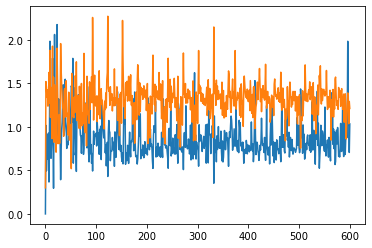

In [82]:
plt.plot(genloss)
plt.plot(discloss)

2/2 [==============================] - 1s 4ms/step


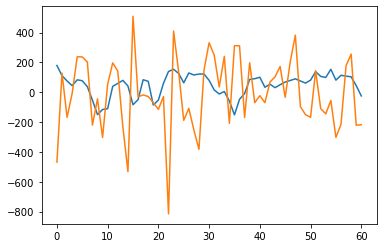

In [83]:
predicted_data = gen_model.predict(X_test)
plt.plot(predicted_data)
plt.plot(y_test)